In [356]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm_notebook

In [432]:
dir = '/content/drive/MyDrive/projects/21_11_dacon_bicycle/'

In [491]:
train_data = pd.read_csv(dir + '_data/train.csv')
test_data = pd.read_csv(dir+'_data/test.csv')
data_set = [train_data, test_data]

In [492]:
y = train_data['number_of_rentals']
train_data.drop('number_of_rentals', axis=1 , inplace=True)

In [493]:
print(train_data.shape)
print(test_data.shape)

(273, 9)
(91, 9)


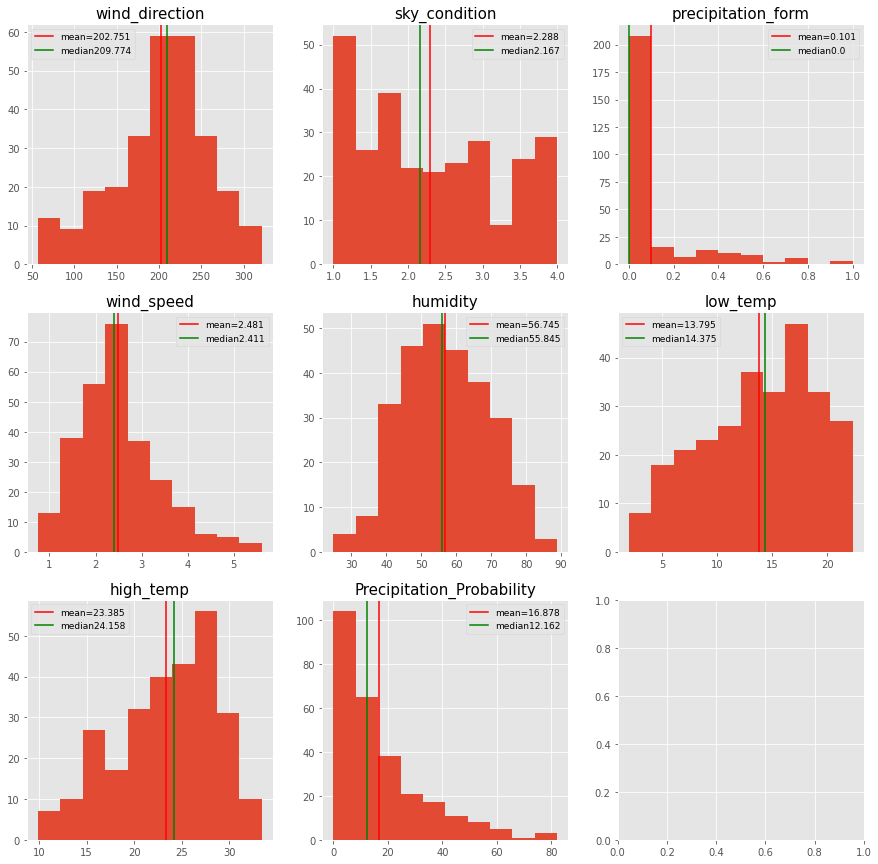

In [494]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
col = 1
for i in range(len(axes)):
  for j in range(len(axes[i])):
    if col > len(train_data.columns) - 1:
      break
    col_name = train_data.columns[col]
    data = train_data[col_name]
    axes[i][j].hist(data)
    axes[i][j].axvline(data.mean(), color='r', label='mean={}'.format(round(data.mean(),3)))
    axes[i][j].axvline(data.median(), color='g', label='median{}'.format(round(data.median(),3)))
    axes[i][j].set_title(col_name, fontsize=15)
    axes[i][j].legend(prop={'size':9})
    col += 1

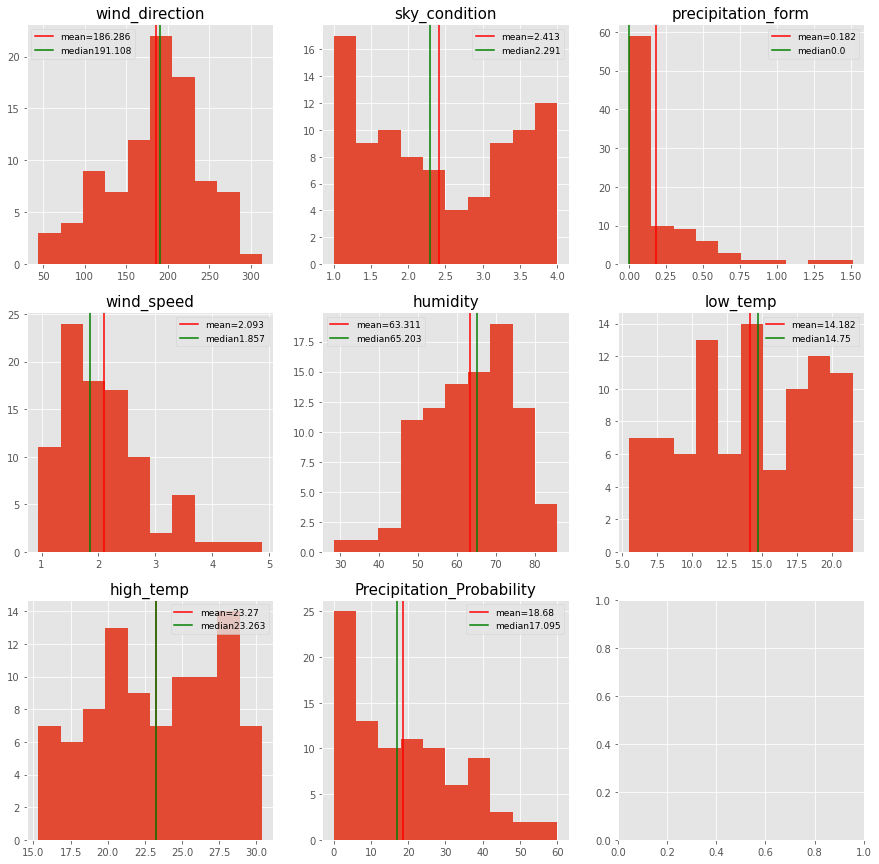

In [495]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
col = 1
for i in range(len(axes)):
  for j in range(len(axes[i])):
    if col > len(test_data.columns) - 1:
      break
    col_name = test_data.columns[col]
    data = test_data[col_name]
    axes[i][j].hist(data)
    axes[i][j].axvline(data.mean(), color='r', label='mean={}'.format(round(data.mean(),3)))
    axes[i][j].axvline(data.median(), color='g', label='median{}'.format(round(data.median(),3)))
    axes[i][j].set_title(col_name, fontsize=15)
    axes[i][j].legend(prop={'size':9})
    col += 1

In [496]:
for D in data_set:
  DT = pd.to_datetime(D['date_time'])
  D['year'] = DT.dt.year
  D['month'] = DT.dt.month
  D['day'] = DT.dt.day
  D['week'] = DT.dt.week
  D['weekday'] = DT.dt.weekday
  D['day'][D['month']==5] += 30
  D['day'][D['month']==6] += 61
  D.drop('date_time', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week in

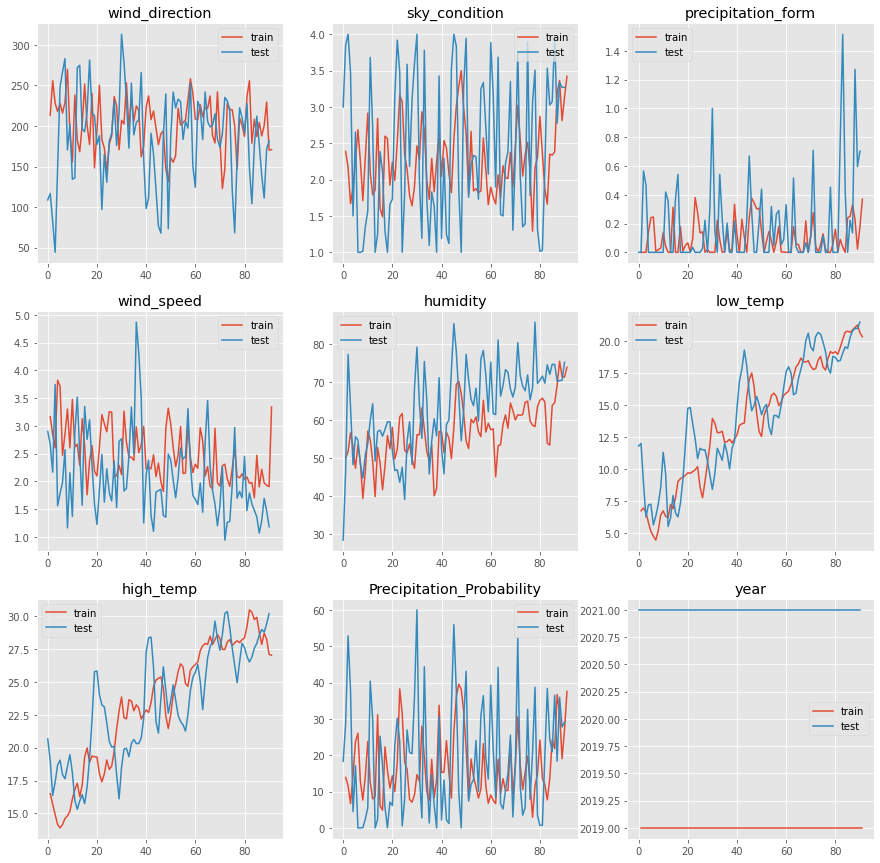

In [497]:
train_mean = train_data.groupby('day').mean()
fig, axes = plt.subplots(3,3,figsize=(15,15))
for D in [train_mean, test_data]:
  col=0
  for i in range(axes.shape[0]):
    for j in range (axes.shape[1]):
      if col > len(D.columns) - 1:
        break
      col_name = D.columns[col]
      data = D[col_name]
      axes[i][j].plot(data)
      axes[i][j].legend(['train', 'test'])
      axes[i][j].set_title('{}'.format(col_name))
      col+=1

2021년은 예년에 비해 날씨가 훨씬 난리

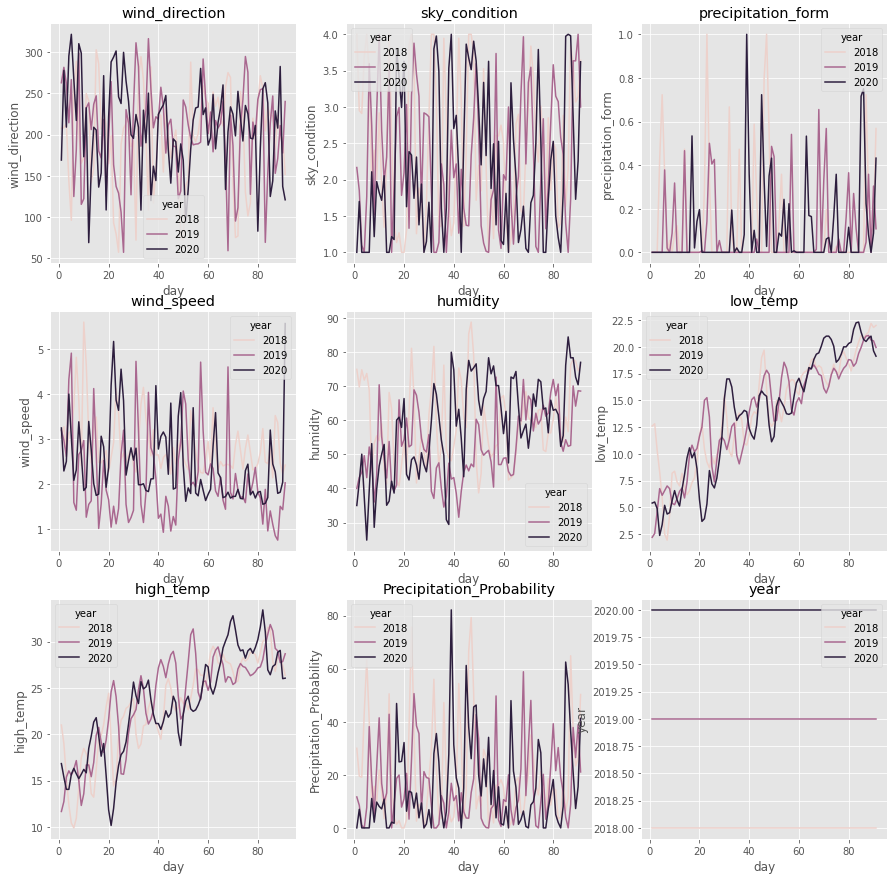

In [498]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
col = 0
for i in range(axes.shape[0]):
  for j in range(axes.shape[1]):
    col_name = train_data.columns[col]
    sns.lineplot(x=train_data['day'],
                  y=train_data[col_name],
                  hue=train_data['year'],
                  ax=axes[i][j]
    )
    axes[i][j].set_title('{}'.format(col_name))
    col += 1

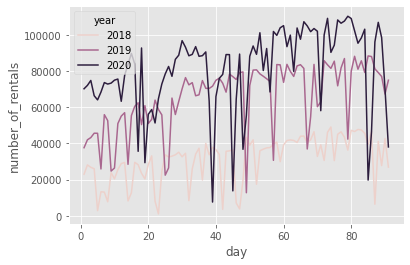

In [499]:
sns.lineplot(x=train_data['day'],
             y=y,
             hue=train_data['year'])

바람의 방향은 360 = 0이다. 매년 어느정도 반복되는 형태가 있으므로 도움이 되겠지만 현재 형태로는 쓸 수 없다. 범주형 데이터로 변환한 뒤 one-hot encoding 하는 것으로 사용

In [506]:
train_new = train_data.copy()
test_new = test_data.copy()

for D in [train_new, test_new]:
    
    #온도 통합 (평균, 최고기온)
    D['temp'] = (D['high_temp'] + D['low_temp']) / 2
    #D.drop(['low_temp'], axis=1, inplace=True)
    
    #체감온도 
    D['feeling_temp'] = 13.12+0.6215*D['temp']-\
                        11.37*D['wind_speed']**(0.16)\
                        +0.3965*D['temp']*D['wind_speed']**(0.16)
    
    #불쾌지수
    D['temp_hum_index'] = 1.8*D['temp'] - 0.55 *\
                          (1 - D['humidity'])*(1.8*D['temp']-26) + 32
    
    D.drop(['temp'], axis=1, inplace=True)
    
    #습도삭제
    #D.drop(['humidity'], axis=1, inplace=True)

    
    #강수확률 vs 강수형태 vs 구름 / 강수확률 우선테스트
    D.drop(['Precipitation_Probability'], axis=1, inplace=True)

    #의미없는 데이터 삭제(일, 요일)
    D['weekend'] =  D['weekday'] > 5
    D.drop(['weekday', 'month', 'week'], axis=1, inplace=True)
    
    #0값을 제거
    D['precipitation_form'] = np.exp(D['precipitation_form'])

    #바람의 방향을 남-북으로 구분
    D['wind_direction'] = np.abs(D['wind_direction'] - 180)


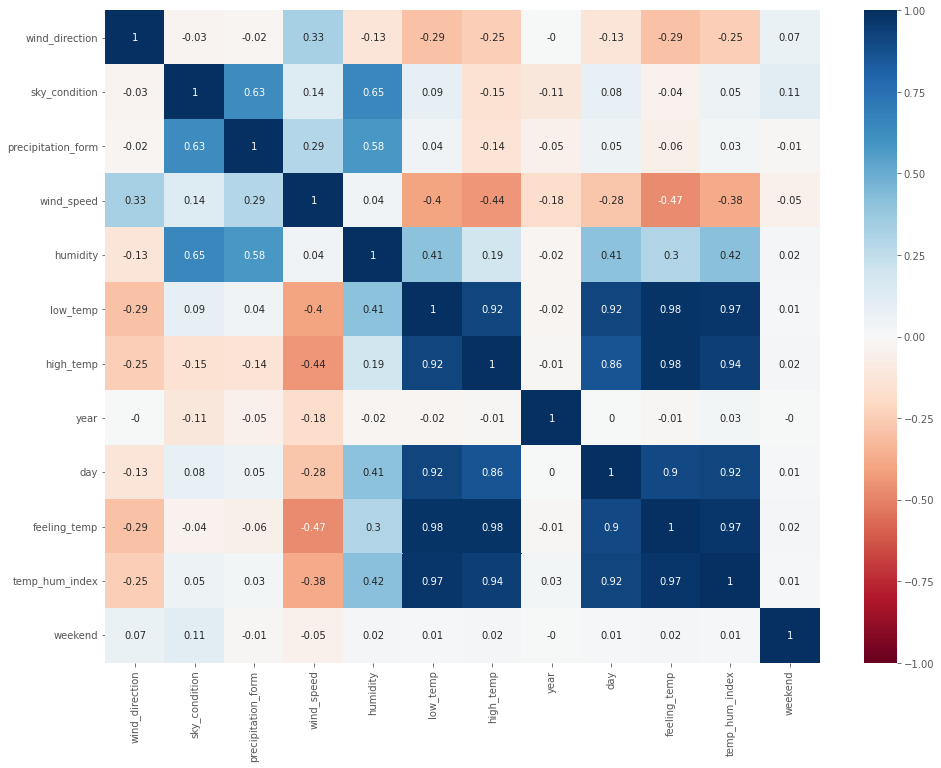

In [507]:
corr = np.round(train_new.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(16,12))
hm = sns.heatmap(corr,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

In [538]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [514]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [542]:
poly = PolynomialFeatures(2)
model = make_pipeline(poly,RandomForestRegressor(max_depth=8))

[07:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


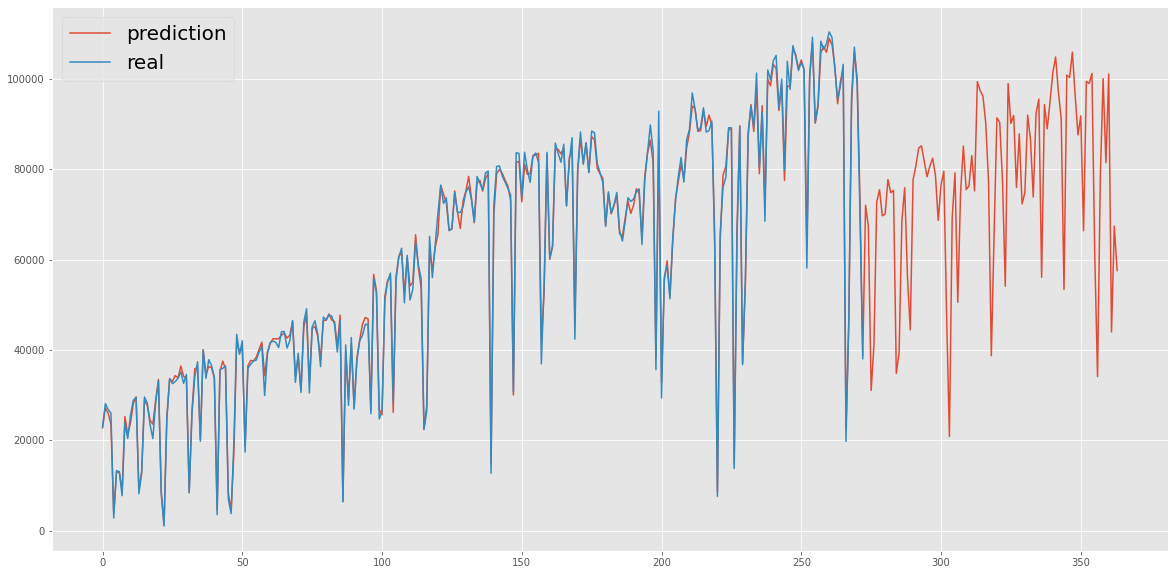

In [567]:
#model = XGBRegressor(tree_model='gpu_hist')
poly = PolynomialFeatures(6)
model = make_pipeline(poly,XGBRegressor(tree_mothod='gpu_hist'))

model.fit(train_new, y)
y_hat = model.predict(train_new)

result = model.predict(test_new)

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([y_hat, result]), label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

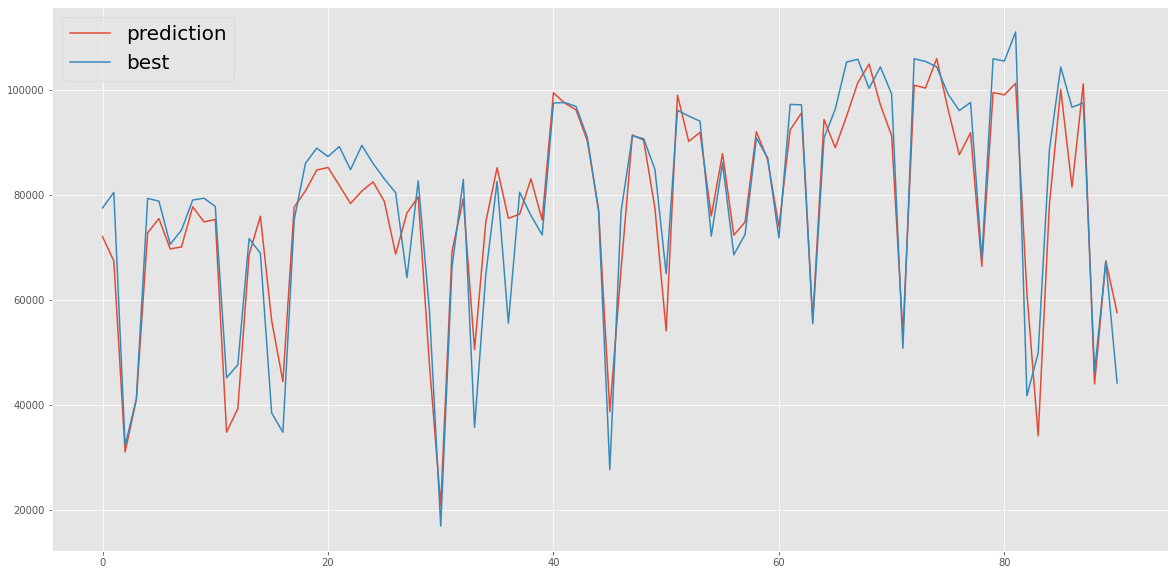

In [569]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot((result), label='prediction')
plt.plot(best['number_of_rentals'], label='best')
#plt.plot(xgb['number_of_rentals'], label='xgb')
plt.legend(fontsize=20)
plt.show()

In [570]:
best = pd.read_csv(dir+'_result/16.initialize.csv')
xgb = pd.read_csv(dir+'_result/7.xgboost.csv')

In [571]:
submission = pd.read_csv(dir + '_data/sample_submission.csv')

In [572]:
submission['number_of_rentals'] = result

In [573]:
submission.to_csv(dir+'_result/18.initialize.csv', index=False)